In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
MENTIONS_COUNTS_FILE = "mentions_counts_by_state_and_months_filtered_5themes.csv"

# External datasets

In [3]:
countries = pd.read_csv("preprocessed_countries.csv")
countries.Country = countries.Country.astype(str).str.strip()
countries.head(5)

,Country,Region,FIPS,ISO2,ISO3
0,Afghanistan,Asia,AF,AF,AFG
1,Albania,Europe,AL,AL,ALB
2,Algeria,Africa,AG,DZ,DZA
3,American Samoa,Oceania,AQ,AS,ASM
4,Andorra,Europe,AN,AD,AND


### Human development index ([source](http://hdr.undp.org/en/content/human-development-index-hdi))

In [4]:
hdi = pd.read_csv("human_development_index_2017.csv")
hdi.head(5)

,HDI Rank,Country,ISO3,2015,2016,2017
0,168,Afghanistan,AFG,0.493,0.494,0.498
1,68,Albania,ALB,0.776,0.782,0.785
2,85,Algeria,DZA,0.749,0.753,0.754
3,35,Andorra,AND,0.854,0.856,0.858
4,147,Angola,AGO,0.572,0.577,0.581


In [5]:
hdi = hdi.set_index("ISO3")[["2017"]]
hdi.rename(columns={"2017":"hdi_2017"}, inplace=True)
hdi.head(5)

,hdi_2017
ISO3,
AFG,0.498
ALB,0.785
DZA,0.754
AND,0.858
AGO,0.581


### Environmental performance index ([source](https://epi.envirocenter.yale.edu/epi-downloads))

In [6]:
epi = pd.read_csv("epi2018countrysnapshotv01.csv")
epi.head(5)

,code,iso,country,Pop,PopGrowthRate,PopDensity,GDP,LandArea,GDPpc,SDGI,EPI2018Score,EPI2018Rank
0,4,AFG,Afghanistan,34.656032,2.689163,53.083405,60.287050,652860.0,1739.583177,46.8,37.74,168
1,8,ALB,Albania,2.876101,-0.159880,104.967190,32.669916,27400.0,11359.099160,68.9,65.46,40
2,12,DZA,Algeria,40.606052,1.825463,17.048895,565.284000,2381741.0,13921.176080,68.8,57.18,88
3,24,AGO,Angola,28.813463,3.367572,23.111786,172.438000,1246700.0,5984.632947,50.2,37.44,170
4,28,ATG,Antigua and Barbuda,0.100963,1.035422,229.461364,2.121537,440.0,21013.017630,NaN,59.18,76


In [7]:
epi = epi[["iso", "country", "GDPpc", "PopDensity", "EPI2018Score"]]
epi = epi.set_index("iso")
epi.head(5)

,country,GDPpc,PopDensity,EPI2018Score
iso,,,,
AFG,Afghanistan,1739.583177,53.083405,37.74
ALB,Albania,11359.099160,104.967190,65.46
DZA,Algeria,13921.176080,17.048895,57.18
AGO,Angola,5984.632947,23.111786,37.44
ATG,Antigua and Barbuda,21013.017630,229.461364,59.18


In [10]:
external_data = hdi.join(epi).join(countries.set_index("ISO3")[["FIPS", "Region"]])
external_data.head(5)

,hdi_2017,country,GDPpc,PopDensity,EPI2018Score,FIPS,Region
ISO3,,,,,,,
AFG,0.498,Afghanistan,1739.583177,53.083405,37.74,AF,Asia
AGO,0.581,Angola,5984.632947,23.111786,37.44,AO,Africa
ALB,0.785,Albania,11359.099160,104.967190,65.46,AL,Europe
AND,0.858,NaN,NaN,NaN,NaN,AN,Europe
ARE,0.863,United Arab Emirates,67133.014840,110.880526,58.90,AE,Asia


# Mentions ratios

In [11]:
mentions_ratios = pd.read_csv(MENTIONS_COUNTS_FILE)
mentions_ratios = mentions_ratios.assign(DATE=pd.to_datetime(mentions_ratios[["YEAR", "MONTH", "DAY"]]))
mentions_ratios.drop(columns=["YEAR", "MONTH", "DAY"], inplace=True)
mentions_ratios.loc[mentions_ratios.ENV_COUNT.isna(), "ENV_COUNT"] = 0
mentions_ratios.sample(10)

,STATE,GLOBAL_COUNT,ENV_COUNT,DATE
178021,BE,3072,50.0,2016-08-29
86851,QA,2416,193.0,2016-09-05
193495,KU,121,0.0,2016-06-11
15793,MZ,312,0.0,2016-07-03
188251,UY,45,9.0,2015-06-20
179139,BB,100,0.0,2016-04-15
100932,RP,5218,54.0,2016-11-13
87229,BA,476,1.0,2016-09-12
17087,RI,968,19.0,2017-02-22
212043,GH,2326,38.0,2016-04-05


In [29]:
means = mentions_ratios.groupby("STATE").mean()
#means = means[means.ENV_COUNT>5]
means = means.assign(MEAN=means.ENV_COUNT/means.GLOBAL_COUNT)[["MEAN"]]
medians = mentions_ratios.groupby("STATE").median()
#medians = medians[medians.ENV_COUNT>5]
medians = medians.assign(MEDIAN=medians.ENV_COUNT/medians.GLOBAL_COUNT)[["MEDIAN"]]

In [30]:
ratios = means.join(medians)
ratios.sample(10)

,MEAN,MEDIAN
STATE,,
KZ,0.065150,0.067183
TU,0.024857,0.023327
US,0.037324,0.028086
RE,0.017823,0.000000
UK,0.024805,0.021792
BU,0.032524,0.026415
TH,0.024567,0.021576
CA,0.049086,0.039837
LG,0.036197,0.015306


# Join to external datasets

In [31]:
joined = ratios.join(external_data.set_index("FIPS", drop=True), how="left")
joined = joined[joined.Region != "Oceania"]
joined.head(5)

,MEAN,MEDIAN,hdi_2017,country,GDPpc,PopDensity,EPI2018Score,Region
AA,0.059964,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
AC,0.268259,0.000000,0.780,Antigua and Barbuda,21013.017630,229.461364,59.18,Americas
AE,0.042461,0.027043,0.863,United Arab Emirates,67133.014840,110.880526,58.90,Asia
AF,0.050577,0.056752,0.498,Afghanistan,1739.583177,53.083405,37.74,Asia
AG,0.116690,0.052478,0.754,Algeria,13921.176080,17.048895,57.18,Africa


In [32]:
joined.describe()

,MEAN,MEDIAN,hdi_2017,GDPpc,PopDensity,EPI2018Score
count,250.000000,250.000000,182.000000,173.000000,173.000000,173.000000
mean,0.064625,0.021938,0.712181,18248.415052,202.113492,56.724913
std,0.090489,0.040113,0.155110,19310.889696,637.400219,13.136901
min,0.000000,0.000000,0.354000,647.880445,1.948684,27.430000
25%,0.024720,0.000000,0.589250,4386.360304,36.660998,46.370000
50%,0.035702,0.016091,0.744000,12260.166610,82.522046,57.180000
75%,0.062400,0.029022,0.836250,24811.144190,204.211425,64.980000
max,0.649563,0.500000,0.953000,118207.069500,7908.720733,87.420000


In [36]:
def lmplot(data, x, y="MEAN", title="", world=False, figsize=(12,6)):
    plt.figure(figsize=figsize)
    plt.suptitle(title)
    sns.lmplot(x, y, data=data, col="Region" if not world else None, robust=True)

<Figure size 864x432 with 0 Axes>

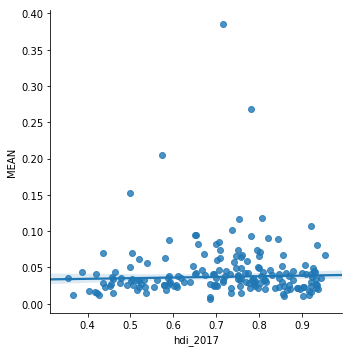

<Figure size 864x432 with 0 Axes>

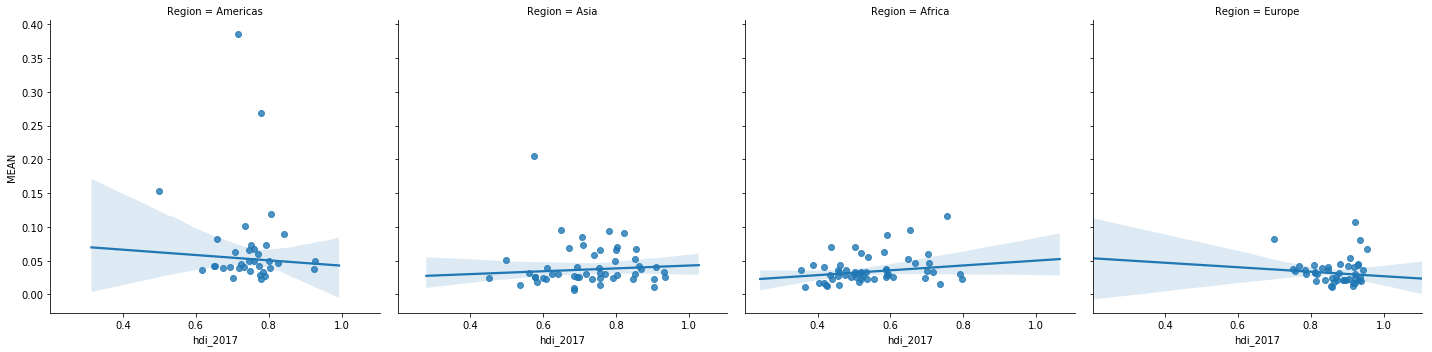

In [41]:
lmplot(joined, "hdi_2017", "MEAN", "Human development index vs ratio mean", world=True)
lmplot(joined, "hdi_2017", "MEAN", "Human development index vs ratio mean", world=False)

<Figure size 864x432 with 0 Axes>

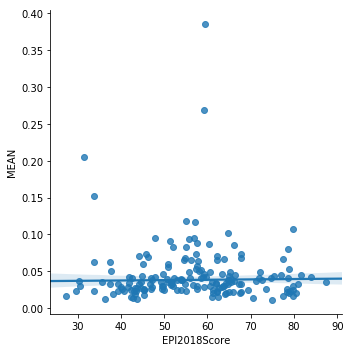

<Figure size 864x432 with 0 Axes>

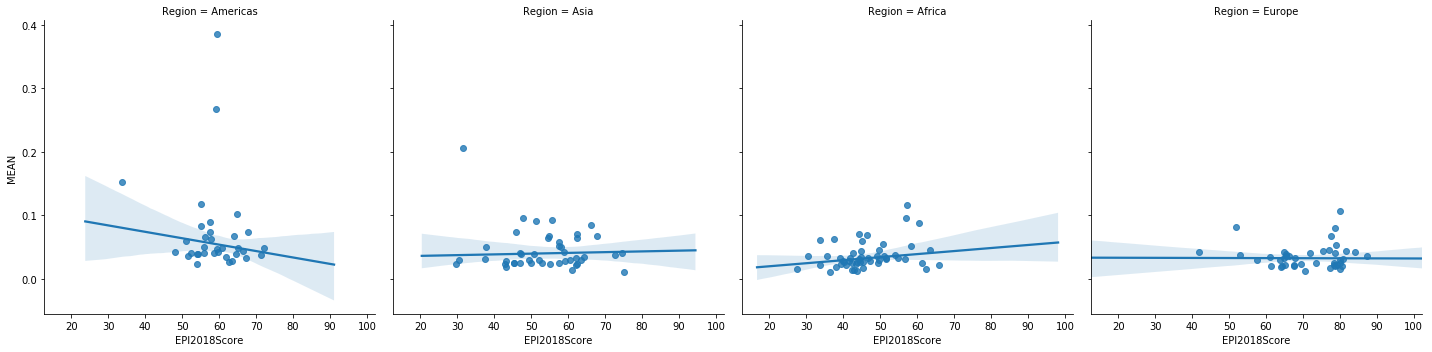

In [42]:
lmplot(joined, "EPI2018Score", "MEAN", "Environmental performance index vs ratio mean", world=True)
lmplot(joined, "EPI2018Score", "MEAN", "Environmental performance index vs ratio mean", world=False)

<Figure size 864x432 with 0 Axes>

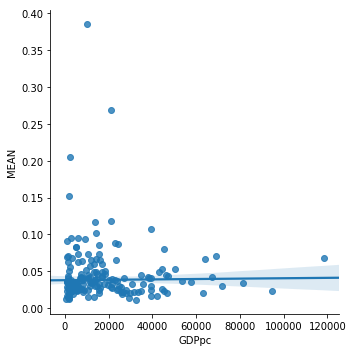

<Figure size 864x432 with 0 Axes>

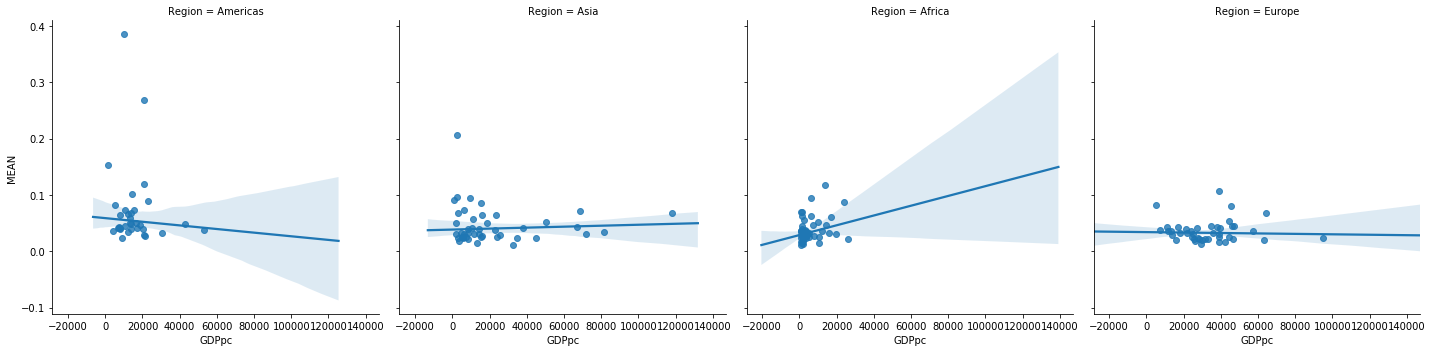

In [43]:
lmplot(joined, "GDPpc", "MEAN", "GDP per capita vs ratio mean", world=True)
lmplot(joined, "GDPpc", "MEAN", "GDP per capita vs ratio mean", world=False)